In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import wandb 

import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import pandas as pd
import sklearn
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import load_boston

import pytorch_lightning as pl

from nam.data import *
from nam.config import *
from nam.models import *
from nam.trainer import *
from nam.utils import *

In [3]:
config = defaults()
print(config)

Config(activation='exu', batch_size=1024, cross_val=False, data_split=1, debug=False, decay_rate=0.995, device='cpu', dropout=0.5, feature_dropout=0.0, fold_num=1, hidden_sizes=[64, 32], l2_regularization=0.0, lr=0.0003, n_models=1, num_basis_functions=1000, num_folds=5, num_splits=3, num_units=64, num_workers=16, optimizer='adam', output_dir='output', output_regularization=0.0, patience=10, regression=True, save_model_frequency=2, seed=1377, shuffle=True, test_split=0.2, training_epochs=10, units_multiplier=2, use_dnn=False, wandb=True)


In [65]:
config.training_epochs = 10
config.output_regularization = 0.99
config.l2_regularization = 0.99
config.batch_size=2048*4
config.feature_dropout = 0.99
# config.num_splits=7
# config.units_multiplier=16
# config.num_units=1024
config.hidden_sizes = [128, 64, 32, 16]
config.wandb = False

In [66]:
data = pd.read_csv("data/GALLUP.csv")
data["WP16"] = np.where(data["WP16"] <= 6, 0, 1)
data = data.sample(frac=0.0001)

In [67]:
len(data)

134

In [68]:
config.regression = False
dataset = FoldedDataset(config, file_path=data,
#                     features_columns = [
#                             "country", "income_2", "WP1219", "WP1220", "year", "weo_gdpc_con_ppp"
#                         ],
                     features_columns = [
                             "income_2", "WP1219", "WP1220", "year","weo_gdpc_con_ppp"
                        ],
                    targets_column= "WP16",)
#                     weights_column= "wgt",)

Found `Nulls` values in the dataset
Your selected dataframe has 8 columns.
There are 1 columns that have missing values.
                  Missing Values  % of Total Values
weo_gdpc_con_ppp               1              0.746


In [69]:
dataset[1]

(tensor([-1.0000,  1.0000, -0.3939, -0.7500, -0.9489]), tensor([0.]))

In [70]:
# for fold, (trainloader, valloader) in enumerate(dataset.train_dataloaders()):
#     print(trainloader, valloader)
# #     print(next(iter(trainloader)))
# #     print(next(iter(valloader)))

In [71]:
# len(dataset.test_dataloaders().dataset)

---
---
---

In [72]:
model = NAM(
  config=config,
  name="NAM_GALLUP",
  num_inputs=len(dataset[0][0]),
  num_units=get_num_units(config, dataset.features),
)
model

/Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/site-packages/torch/nn/init.py:162: UserWarning: mean is more than 2 std from [a, b] in nn.init.trunc_normal_. The distribution of values may be incorrect.
  return _no_grad_trunc_normal_(tensor, mean, std, a, b)


NAM(
  (feature_nns): ModuleList(
    (0): FeatureNN(
      (model): ModuleList(
        (0): ExU(in_features=1, out_features=268)
        (1): LinReLU(in_features=268, out_features=128)
        (2): LinReLU(in_features=128, out_features=64)
        (3): LinReLU(in_features=64, out_features=32)
        (4): LinReLU(in_features=32, out_features=16)
        (5): Linear(in_features=16, out_features=1, bias=True)
      )
    )
    (1): FeatureNN(
      (model): ModuleList(
        (0): ExU(in_features=1, out_features=4)
        (1): LinReLU(in_features=4, out_features=128)
        (2): LinReLU(in_features=128, out_features=64)
        (3): LinReLU(in_features=64, out_features=32)
        (4): LinReLU(in_features=32, out_features=16)
        (5): Linear(in_features=16, out_features=1, bias=True)
      )
    )
    (2): FeatureNN(
      (model): ModuleList(
        (0): ExU(in_features=1, out_features=104)
        (1): LinReLU(in_features=104, out_features=128)
        (2): LinReLU(in_feature

In [73]:
for fold, (trainloader, valloader) in enumerate(dataset.train_dataloaders()):

    # Folder hack
    tb_logger = pl.loggers.TensorBoardLogger(
      save_dir=config.output_dir,
      name=f'{model.name}',
      version=f'fold_{fold + 1}',
    )

    checkpoint_callback = pl.callbacks.model_checkpoint.ModelCheckpoint(
      filename=tb_logger.log_dir + "/{epoch:02d}-{val_loss:.4f}",
      monitor='val_loss',
      save_top_k=3,
      mode='min',
    )

    litmodel = LitNAM(config, model)
    trainer = pl.Trainer(logger=tb_logger,
                         max_epochs=config.training_epochs,
                        checkpoint_callback=checkpoint_callback)
    trainer.fit(litmodel,
              train_dataloader=trainloader,
              val_dataloaders=valloader)

2021-05-01 03:44:29.422 | INFO     | nam.data.folded:train_dataloaders:90 - Fold[1]: train: 77, val: 12
GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name  | Type | Params
-------------------------------
0 | model | NAM  | 137 K 
-------------------------------
137 K     Trainable params
0         Non-trainable params
137 K     Total params
0.550     Total estimated model params size (MB)
/Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Validation sanity check: 0it [00:00, ?it/s]

/Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

2021-05-01 03:44:30.391 | INFO     | nam.data.folded:train_dataloaders:90 - Fold[2]: train: 77, val: 12
GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name  | Type | Params
-------------------------------
0 | model | NAM  | 137 K 
-------------------------------
137 K     Trainable params
0         Non-trainable params
137 K     Total params
0.550     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

2021-05-01 03:44:31.286 | INFO     | nam.data.folded:train_dataloaders:90 - Fold[3]: train: 77, val: 12
GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name  | Type | Params
-------------------------------
0 | model | NAM  | 137 K 
-------------------------------
137 K     Trainable params
0         Non-trainable params
137 K     Total params
0.550     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

2021-05-01 03:44:32.242 | INFO     | nam.data.folded:train_dataloaders:90 - Fold[4]: train: 77, val: 12
GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name  | Type | Params
-------------------------------
0 | model | NAM  | 137 K 
-------------------------------
137 K     Trainable params
0         Non-trainable params
137 K     Total params
0.550     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

2021-05-01 03:44:33.172 | INFO     | nam.data.folded:train_dataloaders:90 - Fold[5]: train: 77, val: 12
GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name  | Type | Params
-------------------------------
0 | model | NAM  | 137 K 
-------------------------------
137 K     Trainable params
0         Non-trainable params
137 K     Total params
0.550     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

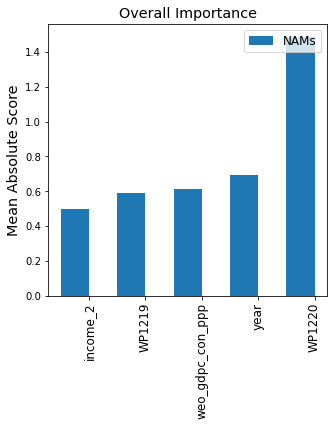

In [74]:
fig = plot_mean_feature_importance(litmodel.model, dataset)

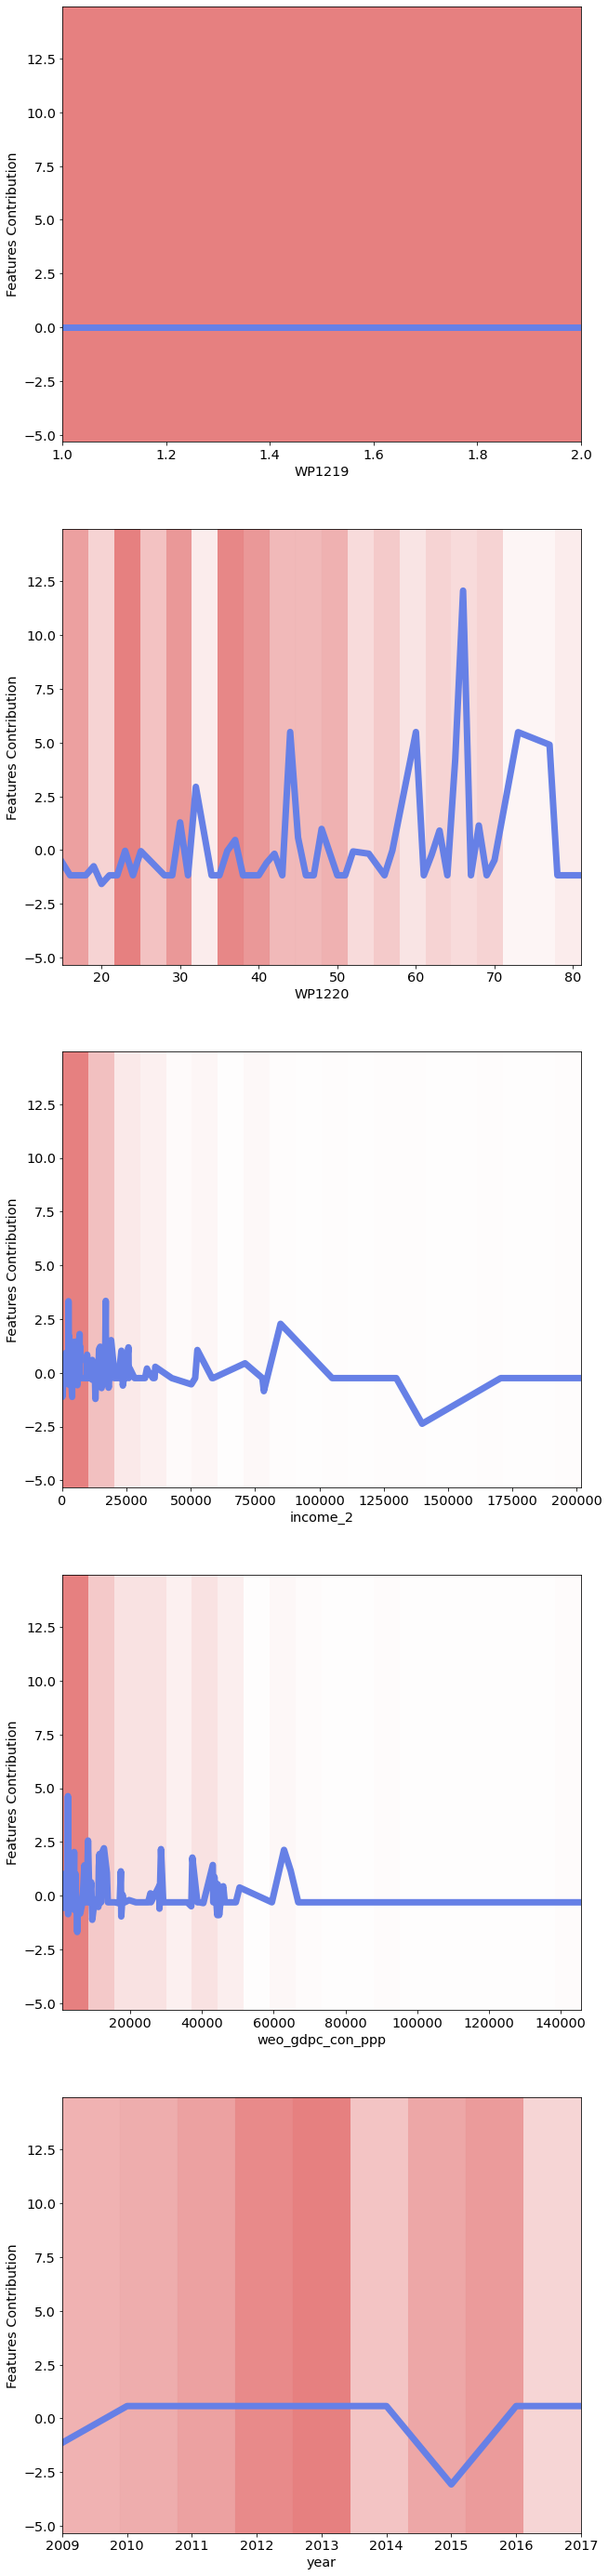

In [76]:
fig = plot_nams(litmodel.model, dataset, num_cols= 1)

In [236]:
train_dl, val_dl, test_dl = dataset.get_dataloaders()

In [237]:
len(train_dl.dataset), len(val_dl.dataset), len(test_dl.dataset)

(9655, 1072, 2681)

In [238]:
model = NAM(
  config=config,
  name="NAM_Housing",
  num_inputs=len(dataset[0][0]),
  num_units=get_num_units(config, dataset.features),
)

trainer = Trainer(config, model, dataset)
trainer.train()
# trainer.test()

/Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/site-packages/torch/nn/init.py:162: UserWarning: mean is more than 2 std from [a, b] in nn.init.trunc_normal_. The distribution of values may be incorrect.
  return _no_grad_trunc_normal_(tensor, mean, std, a, b)


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/151 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/151 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/151 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

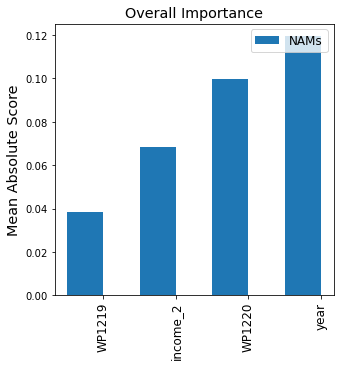

In [239]:
fig = plot_mean_feature_importance(model, dataset)

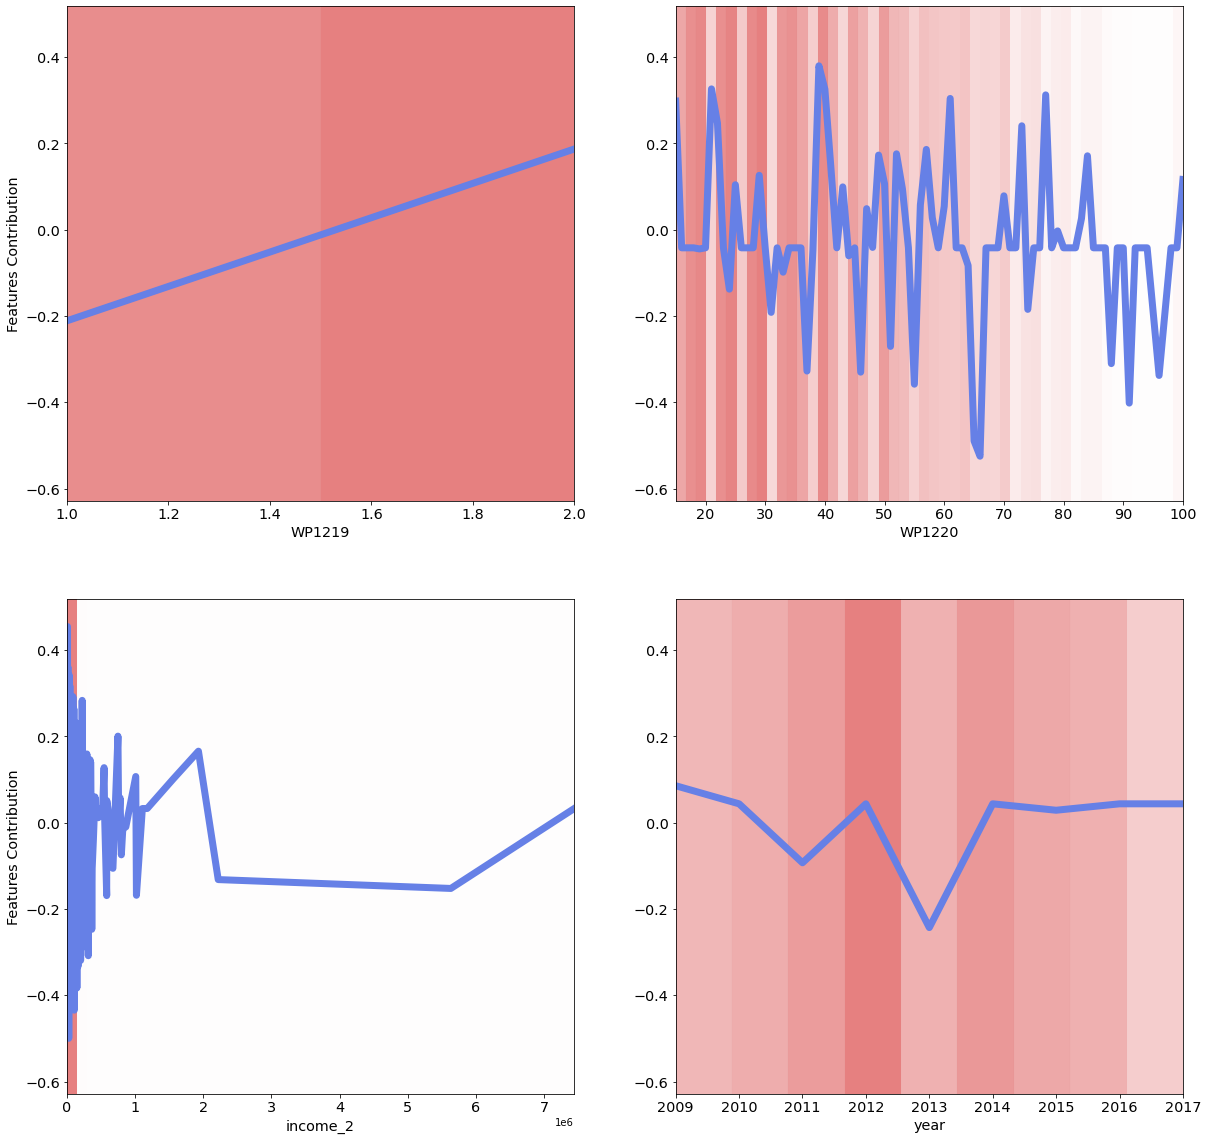

In [240]:
fig = plot_nams(model, dataset, num_cols= 2)

In [208]:
model

NAM(
  (feature_nns): ModuleList(
    (0): FeatureNN(
      (model): ModuleList(
        (0): ExU(in_features=1, out_features=1000)
        (1): LinReLU(in_features=1000, out_features=128)
        (2): LinReLU(in_features=128, out_features=64)
        (3): LinReLU(in_features=64, out_features=32)
        (4): LinReLU(in_features=32, out_features=16)
        (5): Linear(in_features=16, out_features=1, bias=True)
      )
    )
    (1): FeatureNN(
      (model): ModuleList(
        (0): ExU(in_features=1, out_features=16)
        (1): LinReLU(in_features=16, out_features=128)
        (2): LinReLU(in_features=128, out_features=64)
        (3): LinReLU(in_features=64, out_features=32)
        (4): LinReLU(in_features=32, out_features=16)
        (5): Linear(in_features=16, out_features=1, bias=True)
      )
    )
    (2): FeatureNN(
      (model): ModuleList(
        (0): ExU(in_features=1, out_features=680)
        (1): LinReLU(in_features=680, out_features=128)
        (2): LinReLU(in_fea

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv("data/GALLUP.csv")

In [2]:
df = df.interpolate(method='linear', axis=0)

In [3]:
X = df[["income_2", "WP1219", "WP1220"]]
y = df["WP16"].apply(lambda x: 0 if x <= 6 else 1) #Turning response into 0 and 1
X, y

(             income_2  WP1219  WP1220
 0        18042.771080     1.0    15.0
 1        12799.412740     1.0    15.0
 2        22448.936000     1.0    15.0
 3        16853.739740     1.0    15.0
 4        22206.487490     1.0    15.0
 ...               ...     ...     ...
 1340804    566.020845     1.0   100.0
 1340805    453.127896     1.0   100.0
 1340806      0.000000     1.0   100.0
 1340807   2869.777740     1.0   100.0
 1340808  35872.221750     1.0   100.0
 
 [1340809 rows x 3 columns],
 0          0
 1          0
 2          1
 3          0
 4          1
           ..
 1340804    0
 1340805    0
 1340806    0
 1340807    0
 1340808    1
 Name: WP16, Length: 1340809, dtype: int64)

In [4]:
seed = 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=seed)

In [5]:
from interpret.glassbox import ExplainableBoostingClassifier, LogisticRegression, ClassificationTree, DecisionListClassifier

ebm = ExplainableBoostingClassifier(random_state=seed, n_jobs=-1)
ebm.fit(X_train, y_train)

ExplainableBoostingClassifier(feature_names=['income_2', 'WP1219', 'WP1220',
                                             'income_2 x WP1220',
                                             'income_2 x WP1219',
                                             'WP1219 x WP1220'],
                              feature_types=['continuous', 'continuous',
                                             'continuous', 'interaction',
                                             'interaction', 'interaction'],
                              n_jobs=-1, random_state=1)

In [6]:
from interpret import show

ebm_global = ebm.explain_global()
show(ebm_global)

<!-- http://127.0.0.1:7001/140256742887312/ -->

In [7]:
ebm_local = ebm.explain_local(X_test, y_test)
show(ebm_local)

<!-- http://127.0.0.1:7001/140257285081488/ -->

## Imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import pandas as pd
import sklearn
from sklearn.datasets import load_breast_cancer

import pytorch_lightning as pl

In [3]:
from nam.data import *
from nam.config import defaults
from nam.models import NAM, DNN, get_num_units
from nam.lit import LitNAM

## Configuration 

In [4]:
config = defaults()
print(config)

Config(activation='exu', batch_size=1024, cross_val=False, data_split=1, debug=False, decay_rate=0.995, device='cpu', dropout=0.5, feature_dropout=0.0, fold_num=1, hidden_sizes=[64, 32], l2_regularization=0.0, lr=0.01, n_folds=5, n_models=1, num_basis_functions=1000, num_splits=3, num_units=64, num_workers=16, optimizer='adam', output_dir='output', output_regularization=0.0, patience=10, regression=True, seed=1377, shuffle=True, test_split=0.2, training_epochs=3, units_multiplier=2, use_dnn=False)


In [5]:
# config.regression = False
## LR smaller
config.batch_size = 1024
config.training_epochs = 10
config.n_models = 10

In [6]:
pl.seed_everything(config.seed)

Global seed set to 1377


1377

## Data

In [7]:
dataset = load_gallup_data(config, 
                           features_columns= ["income_2", "WP1219", "WP1220", "weo_gdpc_con_ppp"])

In [8]:
dataset

NAMDatasetSample(
	features=tensor([1.7826e-05, 1.0000e+00, 4.3678e-01, 1.5401e-02]), 
	targets=tensor([0.]), 
	weights=0.19573742151260376
)

In [9]:
train_dl, val_dl, test_dl = dataset.get_dataloaders()

In [10]:
len(train_dl.dataset), len(val_dl.dataset), len(test_dl.dataset)

(241346, 26816, 67040)

---
---

## NAM models

In [11]:
## TODO: List instead of deepcopy

model = NAM(
      config=config,
      name="NAMModel_GALLUP",
      num_inputs=len(dataset[0][0]),
      num_units=get_num_units(config, dataset.features),
)
model

/Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/site-packages/torch/nn/init.py:162: UserWarning: mean is more than 2 std from [a, b] in nn.init.trunc_normal_. The distribution of values may be incorrect.
  return _no_grad_trunc_normal_(tensor, mean, std, a, b)


NAM(
  (feature_nns): ModuleList(
    (0): FeatureNN(
      (model): ModuleList(
        (0): ExU(in_features=1, out_features=1000)
        (1): LinReLU(in_features=1000, out_features=64)
        (2): LinReLU(in_features=64, out_features=32)
        (3): Linear(in_features=32, out_features=1, bias=True)
      )
    )
    (1): FeatureNN(
      (model): ModuleList(
        (0): ExU(in_features=1, out_features=4)
        (1): LinReLU(in_features=4, out_features=64)
        (2): LinReLU(in_features=64, out_features=32)
        (3): Linear(in_features=32, out_features=1, bias=True)
      )
    )
    (2): FeatureNN(
      (model): ModuleList(
        (0): ExU(in_features=1, out_features=208)
        (1): LinReLU(in_features=208, out_features=64)
        (2): LinReLU(in_features=64, out_features=32)
        (3): Linear(in_features=32, out_features=1, bias=True)
      )
    )
    (3): FeatureNN(
      (model): ModuleList(
        (0): ExU(in_features=1, out_features=1000)
        (1): LinReLU(

In [12]:

import copy
litnams = [LitNAM(config, copy.deepcopy(model)) for _ in range(config.n_models)]
# engine

In [13]:
checkpoint_callback = pl.callbacks.model_checkpoint.ModelCheckpoint(
    dirpath=f"{config.output_dir}/{model.name}/checkpoints",
    filename=model.name + "-{epoch:02d}-{val_loss:.4f}", 
    monitor='val_loss', 
    save_top_k=3,
    mode='min'
)

/Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning: Checkpoint directory output/NAMModel_GALLUP/checkpoints exists and is not empty.
  warnings.warn(*args, **kwargs)


In [14]:
for litnam in litnams:
    trainer = pl.Trainer(
        default_root_dir=f"{config.output_dir}/{model.name}",
        max_epochs=config.training_epochs,
        callbacks=[checkpoint_callback],
    )
    trainer.fit(model=litnam, train_dataloader=train_dl, val_dataloaders=val_dl)

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name  | Type | Params
-------------------------------
0 | model | NAM  | 154 K 
-------------------------------
154 K     Trainable params
0         Non-trainable params
154 K     Total params
0.618     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name  | Type | Params
-------------------------------
0 | model | NAM  | 154 K 
-------------------------------
154 K     Trainable params
0         Non-trainable params
154 K     Total params
0.618     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name  | Type | Params
-------------------------------
0 | model | NAM  | 154 K 
-------------------------------
154 K     Trainable params
0         Non-trainable params
154 K     Total params
0.618     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name  | Type | Params
-------------------------------
0 | model | NAM  | 154 K 
-------------------------------
154 K     Trainable params
0         Non-trainable params
154 K     Total params
0.618     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name  | Type | Params
-------------------------------
0 | model | NAM  | 154 K 
-------------------------------
154 K     Trainable params
0         Non-trainable params
154 K     Total params
0.618     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name  | Type | Params
-------------------------------
0 | model | NAM  | 154 K 
-------------------------------
154 K     Trainable params
0         Non-trainable params
154 K     Total params
0.618     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name  | Type | Params
-------------------------------
0 | model | NAM  | 154 K 
-------------------------------
154 K     Trainable params
0         Non-trainable params
154 K     Total params
0.618     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name  | Type | Params
-------------------------------
0 | model | NAM  | 154 K 
-------------------------------
154 K     Trainable params
0         Non-trainable params
154 K     Total params
0.618     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name  | Type | Params
-------------------------------
0 | model | NAM  | 154 K 
-------------------------------
154 K     Trainable params
0         Non-trainable params
154 K     Total params
0.618     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name  | Type | Params
-------------------------------
0 | model | NAM  | 154 K 
-------------------------------
154 K     Trainable params
0         Non-trainable params
154 K     Total params
0.618     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [15]:
for litnam in litnams:
    trainer.test(model=litnam, test_dataloaders=test_dl)

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Accuracy_metric': 0.5562499761581421,
 'Accuracy_metric_epoch': 0.5714051127433777,
 'test_loss': 0.6679108738899231,
 'test_loss_epoch': 0.6641916036605835}
--------------------------------------------------------------------------------


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Accuracy_metric': 0.5395833253860474,
 'Accuracy_metric_epoch': 0.558666467666626,
 'test_loss': 0.6783040761947632,
 'test_loss_epoch': 0.6646039485931396}
--------------------------------------------------------------------------------


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Accuracy_metric': 0.5854166746139526,
 'Accuracy_metric_epoch': 0.5664379596710205,
 'test_loss': 0.6515832543373108,
 'test_loss_epoch': 0.663510262966156}
--------------------------------------------------------------------------------


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Accuracy_metric': 0.5375000238418579,
 'Accuracy_metric_epoch': 0.5456295013427734,
 'test_loss': 0.6694233417510986,
 'test_loss_epoch': 0.6661562919616699}
--------------------------------------------------------------------------------


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Accuracy_metric': 0.543749988079071,
 'Accuracy_metric_epoch': 0.5517452359199524,
 'test_loss': 0.6772692203521729,
 'test_loss_epoch': 0.6669297814369202}
--------------------------------------------------------------------------------


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Accuracy_metric': 0.5270833373069763,
 'Accuracy_metric_epoch': 0.5463007092475891,
 'test_loss': 0.6787272691726685,
 'test_loss_epoch': 0.6705914735794067}
--------------------------------------------------------------------------------


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Accuracy_metric': 0.5666666626930237,
 'Accuracy_metric_epoch': 0.5554892420768738,
 'test_loss': 0.6635338068008423,
 'test_loss_epoch': 0.6645623445510864}
--------------------------------------------------------------------------------


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Accuracy_metric': 0.5291666388511658,
 'Accuracy_metric_epoch': 0.5483741164207458,
 'test_loss': 0.6695238947868347,
 'test_loss_epoch': 0.665752649307251}
--------------------------------------------------------------------------------


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Accuracy_metric': 0.5541666746139526,
 'Accuracy_metric_epoch': 0.5579653978347778,
 'test_loss': 0.6621142029762268,
 'test_loss_epoch': 0.6644724607467651}
--------------------------------------------------------------------------------


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Accuracy_metric': 0.5687500238418579,
 'Accuracy_metric_epoch': 0.5717183947563171,
 'test_loss': 0.6607704758644104,
 'test_loss_epoch': 0.6631055474281311}
--------------------------------------------------------------------------------


In [16]:
models = [litnam.model for litnam in litnams]

In [17]:
from nam.utils.graphing import *

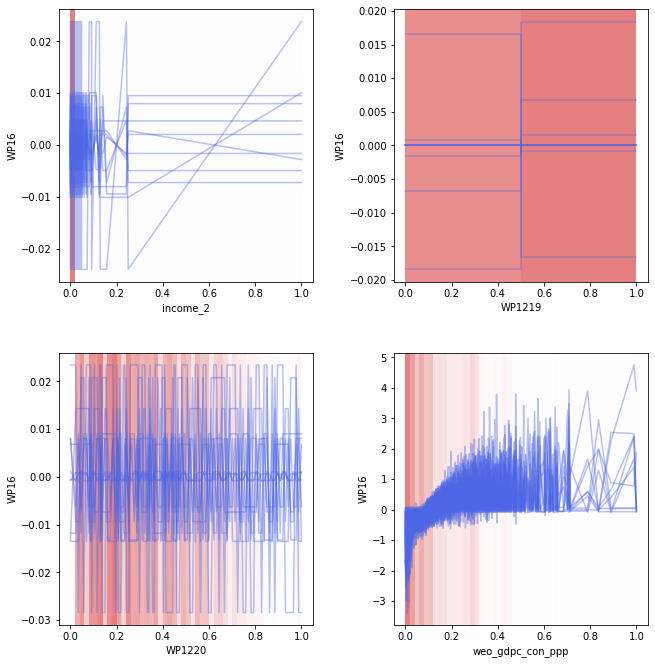

In [18]:
nam_plot(dataset, models)

In [ ]:
## decrease lr
## Add regularization
## increase batch_size

---
---
---

## Housing Data

In [30]:
config.lr = 0.00674
config.output_regularization = 0.001
config.decay_rate = 1e-6
config.dropout = 0.0
config.feature_dropout = 0.0
config.hidden_sizes = [64,32,32]
config.activation = "relu"
config.n_models = 5

In [31]:
dataset = load_housing_data(config)

In [32]:
dataset

NAMDatasetSample(features=tensor([0.7211, 0.0223, 0.3725, 0.0423, 0.0726, 0.0361, 0.0730, 0.1096]), targets=tensor([1.]))

In [33]:
train_dl, val_dl, test_dl = dataset.get_dataloaders()

In [34]:
len(train_dl.dataset), len(val_dl.dataset), len(test_dl.dataset)

(14861, 1651, 4128)

---
---

## NAM models

In [35]:
models = []
for _ in range(config.n_models):
    models.append(NAM(
          config=config,
          name="NAMModel_GALLUP",
          num_inputs=len(dataset[0][0]),
          num_units=get_num_units(config, dataset.features),
    ))

In [37]:
litnams = [LitNAM(config, model) for model in models]
# engine

In [38]:
checkpoint_callback = pl.callbacks.model_checkpoint.ModelCheckpoint(
    dirpath=f"{config.output_dir}/{model.name}/checkpoints",
    filename=model.name + "-{epoch:02d}-{val_loss:.4f}", 
    monitor='val_loss', 
    save_top_k=3,
    mode='min'
)

/Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning: Checkpoint directory output/NAMModel_GALLUP/checkpoints exists and is not empty.
  warnings.warn(*args, **kwargs)


In [39]:
for litnam in litnams:
    trainer = pl.Trainer(
        default_root_dir=f"{config.output_dir}/{model.name}",
        max_epochs=config.training_epochs,
        callbacks=[checkpoint_callback],
    )
    trainer.fit(model=litnam, train_dataloader=train_dl, val_dataloaders=val_dl)

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name  | Type | Params
-------------------------------
0 | model | NAM  | 494 K 
-------------------------------
494 K     Trainable params
0         Non-trainable params
494 K     Total params
1.978     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name  | Type | Params
-------------------------------
0 | model | NAM  | 494 K 
-------------------------------
494 K     Trainable params
0         Non-trainable params
494 K     Total params
1.978     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name  | Type | Params
-------------------------------
0 | model | NAM  | 494 K 
-------------------------------
494 K     Trainable params
0         Non-trainable params
494 K     Total params
1.978     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name  | Type | Params
-------------------------------
0 | model | NAM  | 494 K 
-------------------------------
494 K     Trainable params
0         Non-trainable params
494 K     Total params
1.978     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name  | Type | Params
-------------------------------
0 | model | NAM  | 494 K 
-------------------------------
494 K     Trainable params
0         Non-trainable params
494 K     Total params
1.978     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [40]:
for litnam in litnams:
    trainer.test(model=litnam, test_dataloaders=test_dl)

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'MAE_metric': 0.15560436248779297,
 'MAE_metric_epoch': 0.16424499452114105,
 'test_loss': 0.045463982969522476,
 'test_loss_epoch': 0.05133125185966492}
--------------------------------------------------------------------------------


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'MAE_metric': 0.14562273025512695,
 'MAE_metric_epoch': 0.15241004526615143,
 'test_loss': 0.04121791943907738,
 'test_loss_epoch': 0.046140413731336594}
--------------------------------------------------------------------------------


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'MAE_metric': 0.18840402364730835,
 'MAE_metric_epoch': 0.18442697823047638,
 'test_loss': 0.0478280633687973,
 'test_loss_epoch': 0.050522107630968094}
--------------------------------------------------------------------------------


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'MAE_metric': 0.14337582886219025,
 'MAE_metric_epoch': 0.146953284740448,
 'test_loss': 0.030422383919358253,
 'test_loss_epoch': 0.03910670056939125}
--------------------------------------------------------------------------------


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'MAE_metric': 0.16820615530014038,
 'MAE_metric_epoch': 0.1804312765598297,
 'test_loss': 0.053800079971551895,
 'test_loss_epoch': 0.0606217235326767}
--------------------------------------------------------------------------------


In [41]:
models = [litnam.model for litnam in litnams]

In [42]:
from nam.utils.graphing import *

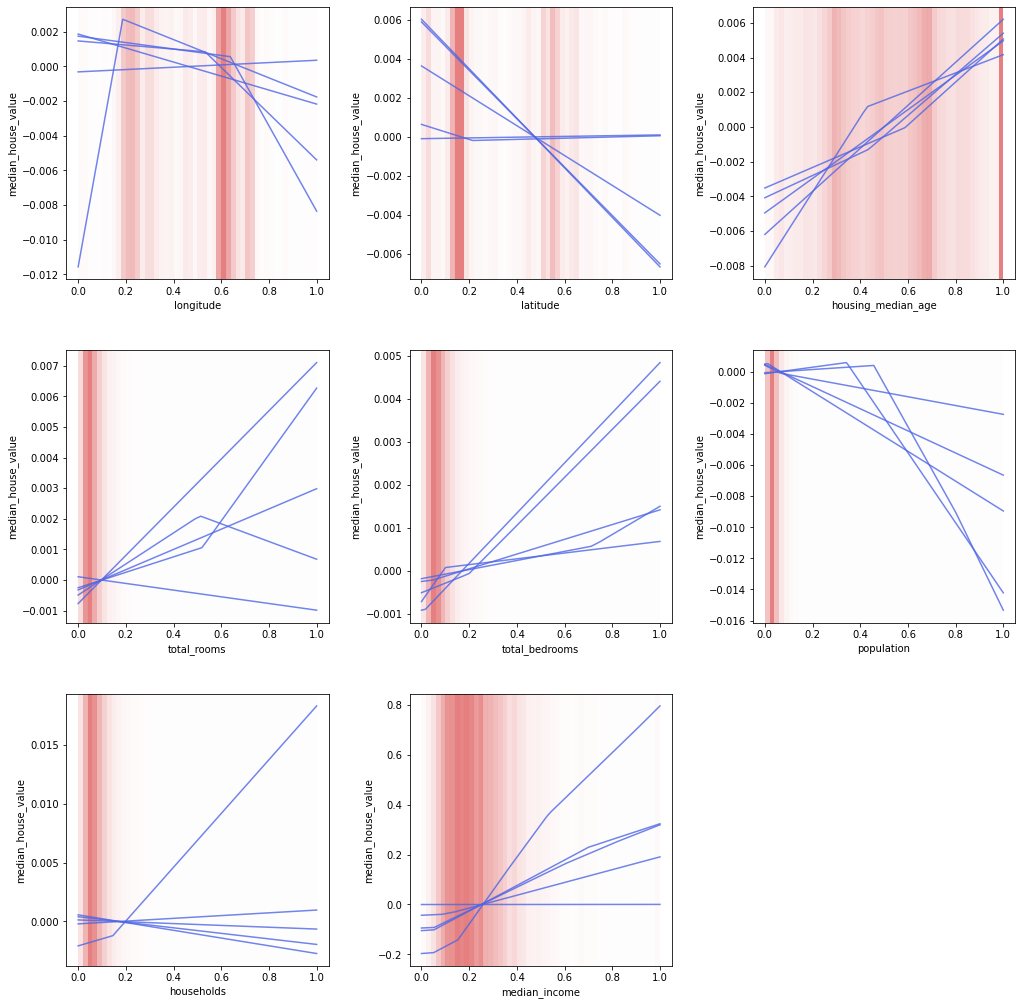

In [43]:
nam_plot(dataset, models)

---
---
---

## Breast Data

In [31]:
dataset = load_breast_data(config)

In [32]:
dataset

NAMDatasetSample(features=tensor([0.6446, 0.6635, 0.6655, 0.4757, 0.5883, 0.7902, 0.8233, 0.7555, 0.6753,
        0.4254, 0.2225, 0.2729, 0.2363, 0.1483, 0.1635, 0.4456, 0.1797, 0.3152,
        0.2161, 0.1828, 0.6336, 0.7303, 0.6683, 0.4020, 0.6196, 0.8158, 0.7498,
        0.9107, 0.4971, 0.4523]), targets=tensor([1.]))

In [33]:
train_dl, val_dl, test_dl = dataset.get_dataloaders()

In [34]:
len(train_dl.dataset), len(val_dl.dataset), len(test_dl.dataset)

(411, 45, 113)

---
---

## NAM models

In [35]:
model = NAM(
      config=config,
      name="NAMModel_GALLUP",
      num_inputs=len(dataset[0][0]),
      num_units=get_num_units(config, dataset.features),
)
model

/Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/site-packages/torch/nn/init.py:162: UserWarning: mean is more than 2 std from [a, b] in nn.init.trunc_normal_. The distribution of values may be incorrect.
  return _no_grad_trunc_normal_(tensor, mean, std, a, b)


NAM(
  (feature_nns): ModuleList(
    (0): FeatureNN(
      (model): ModuleList(
        (0): ExU(in_features=1, out_features=912)
        (1): LinReLU(in_features=912, out_features=64)
        (2): LinReLU(in_features=64, out_features=32)
        (3): Linear(in_features=32, out_features=1, bias=True)
      )
    )
    (1): FeatureNN(
      (model): ModuleList(
        (0): ExU(in_features=1, out_features=958)
        (1): LinReLU(in_features=958, out_features=64)
        (2): LinReLU(in_features=64, out_features=32)
        (3): Linear(in_features=32, out_features=1, bias=True)
      )
    )
    (2): FeatureNN(
      (model): ModuleList(
        (0): ExU(in_features=1, out_features=1000)
        (1): LinReLU(in_features=1000, out_features=64)
        (2): LinReLU(in_features=64, out_features=32)
        (3): Linear(in_features=32, out_features=1, bias=True)
      )
    )
    (3): FeatureNN(
      (model): ModuleList(
        (0): ExU(in_features=1, out_features=1000)
        (1): LinR

In [36]:
import copy
litnams = [LitNAM(config, copy.deepcopy(model)) for _ in range(config.n_models)]
# engine

In [37]:
checkpoint_callback = pl.callbacks.model_checkpoint.ModelCheckpoint(
    dirpath=f"{config.output_dir}/{model.name}/checkpoints",
    filename=model.name + "-{epoch:02d}-{val_loss:.4f}", 
    monitor='val_loss', 
    save_top_k=3,
    mode='min'
)

/Users/amrmkayid/anaconda3/envs/nam/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning: Checkpoint directory output/NAMModel_GALLUP/checkpoints exists and is not empty.
  warnings.warn(*args, **kwargs)


In [38]:
for litnam in litnams:
    trainer = pl.Trainer(
        default_root_dir=f"{config.output_dir}/{model.name}",
        max_epochs=config.training_epochs,
        callbacks=[checkpoint_callback],
    )
    trainer.fit(model=litnam, train_dataloader=train_dl, val_dataloaders=val_dl)

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name  | Type | Params
-------------------------------
0 | model | NAM  | 2.0 M 
-------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.018     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name  | Type | Params
-------------------------------
0 | model | NAM  | 2.0 M 
-------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.018     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name  | Type | Params
-------------------------------
0 | model | NAM  | 2.0 M 
-------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.018     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name  | Type | Params
-------------------------------
0 | model | NAM  | 2.0 M 
-------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.018     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name  | Type | Params
-------------------------------
0 | model | NAM  | 2.0 M 
-------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.018     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name  | Type | Params
-------------------------------
0 | model | NAM  | 2.0 M 
-------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.018     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name  | Type | Params
-------------------------------
0 | model | NAM  | 2.0 M 
-------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.018     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name  | Type | Params
-------------------------------
0 | model | NAM  | 2.0 M 
-------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.018     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name  | Type | Params
-------------------------------
0 | model | NAM  | 2.0 M 
-------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.018     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name  | Type | Params
-------------------------------
0 | model | NAM  | 2.0 M 
-------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.018     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [39]:
for litnam in litnams:
    trainer.test(model=litnam, test_dataloaders=test_dl)

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Accuracy_metric': 0.6548672318458557,
 'Accuracy_metric_epoch': 0.6548672318458557,
 'test_loss': 5.870421886444092,
 'test_loss_epoch': 5.870421886444092}
--------------------------------------------------------------------------------


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Accuracy_metric': 0.6902654767036438,
 'Accuracy_metric_epoch': 0.6902654767036438,
 'test_loss': 6.046410083770752,
 'test_loss_epoch': 6.046410083770752}
--------------------------------------------------------------------------------


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Accuracy_metric': 0.8141592741012573,
 'Accuracy_metric_epoch': 0.8141592741012573,
 'test_loss': 6.60930061340332,
 'test_loss_epoch': 6.60930061340332}
--------------------------------------------------------------------------------


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Accuracy_metric': 0.6991150379180908,
 'Accuracy_metric_epoch': 0.6991150379180908,
 'test_loss': 5.085880279541016,
 'test_loss_epoch': 5.085880279541016}
--------------------------------------------------------------------------------


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Accuracy_metric': 0.8584070801734924,
 'Accuracy_metric_epoch': 0.8584070801734924,
 'test_loss': 6.089895725250244,
 'test_loss_epoch': 6.089895725250244}
--------------------------------------------------------------------------------


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Accuracy_metric': 0.7964601516723633,
 'Accuracy_metric_epoch': 0.7964601516723633,
 'test_loss': 6.270593643188477,
 'test_loss_epoch': 6.270593643188477}
--------------------------------------------------------------------------------


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Accuracy_metric': 0.8407079577445984,
 'Accuracy_metric_epoch': 0.8407079577445984,
 'test_loss': 2.0409679412841797,
 'test_loss_epoch': 2.0409679412841797}
--------------------------------------------------------------------------------


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Accuracy_metric': 0.8495575189590454,
 'Accuracy_metric_epoch': 0.8495575189590454,
 'test_loss': 2.0764360427856445,
 'test_loss_epoch': 2.0764360427856445}
--------------------------------------------------------------------------------


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Accuracy_metric': 0.8672566413879395,
 'Accuracy_metric_epoch': 0.8672566413879395,
 'test_loss': 2.1026787757873535,
 'test_loss_epoch': 2.1026787757873535}
--------------------------------------------------------------------------------


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Accuracy_metric': 0.6548672318458557,
 'Accuracy_metric_epoch': 0.6548672318458557,
 'test_loss': 10.047464370727539,
 'test_loss_epoch': 10.047464370727539}
--------------------------------------------------------------------------------


In [40]:
models = [litnam.model for litnam in litnams]

In [41]:
from nam.utils.graphing import *

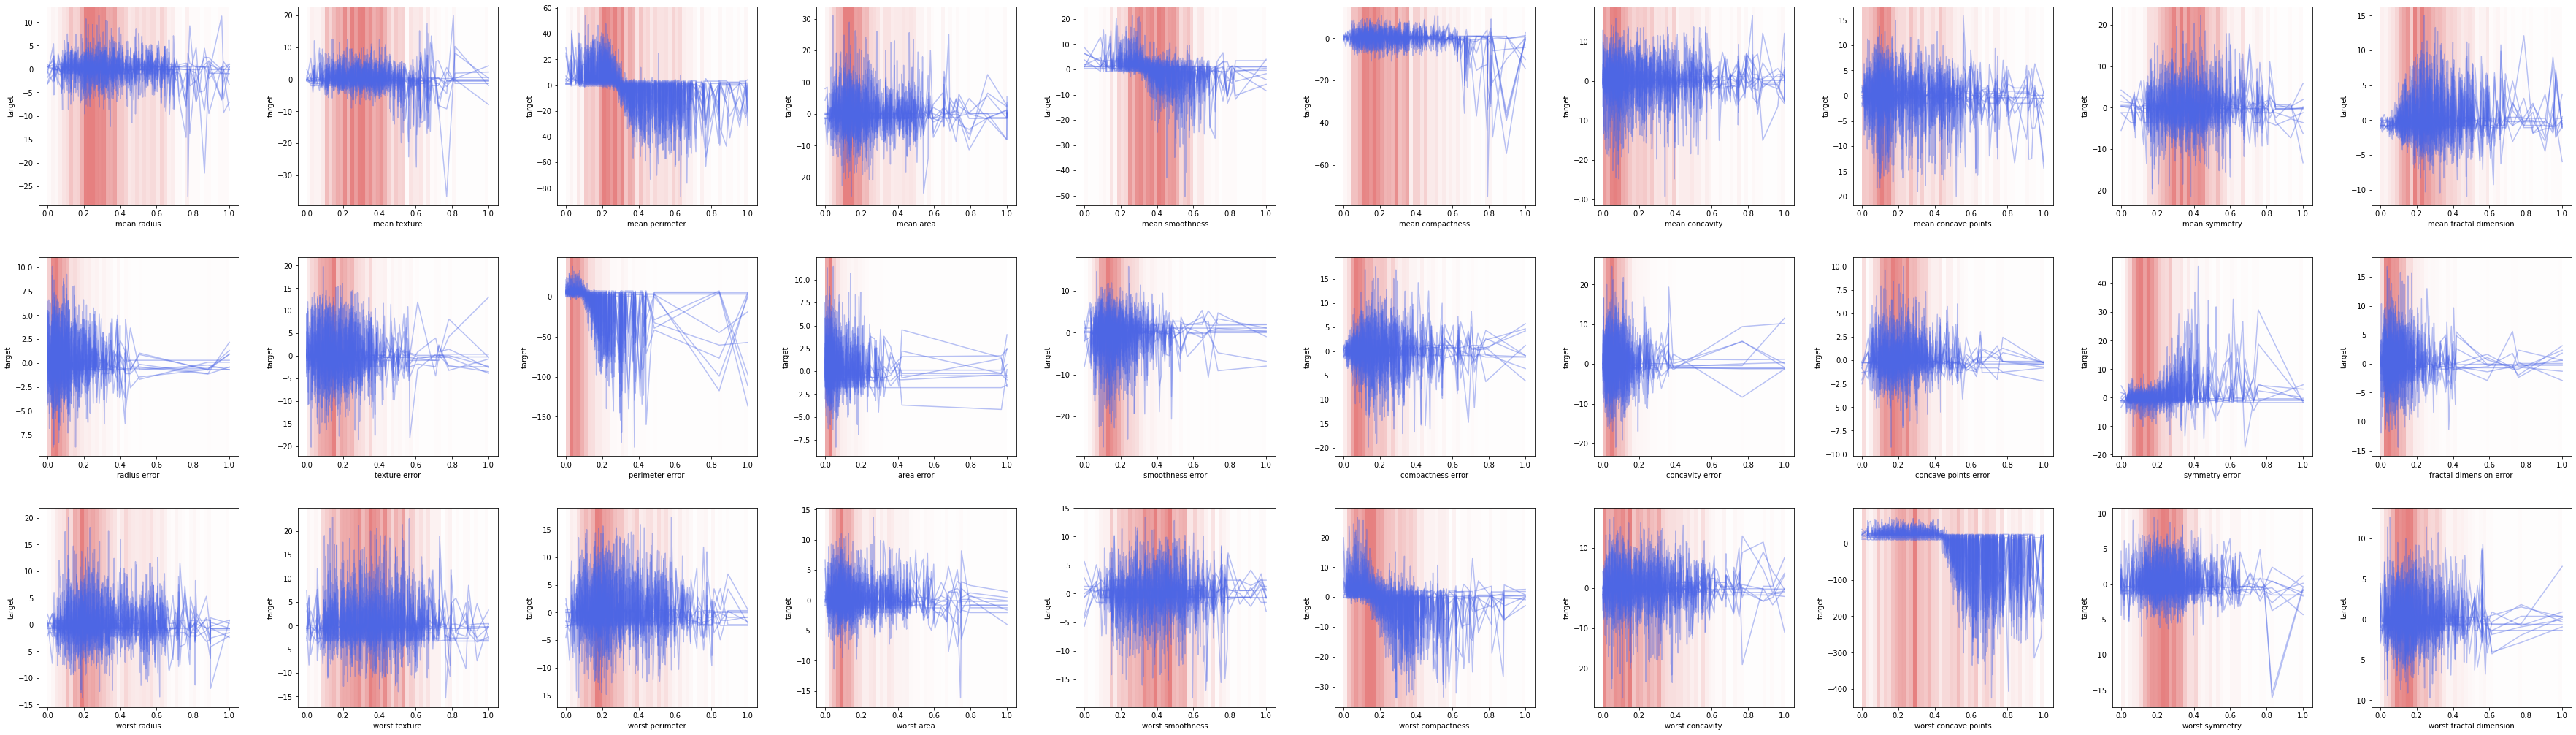

In [42]:
nam_plot(dataset, models)

---
---
---